In [30]:
import os
import math
import pickle
import numpy as np
import pandas as pd
import cv2
from collections import Counter
import matplotlib.pyplot as plt

from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline


In [31]:
# try to import imblearn (SMOTE & pipeline). If missing fallback will be used.
USE_SMOTE = True
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
except Exception:
    USE_SMOTE = False
    ImbPipeline = None
    print("[WARN] imbalanced-learn not available. Script will use class_weight='balanced' instead of SMOTE.")

# ----------------- USER CONFIG -----------------
IMAGES_DIR = "all-mias"
META_PATH = "data2.txt"
IMAGE_SIZE = 1024               # MIAS image size reference
TARGET_SIZE = 128               # None to keep native crop size, or int to resize 128
MIN_SIDE = 32                   # pad if ROI smaller
CLAHE_CLIP = 2.0
CLAHE_TILE = (8, 8)

# LBP params
P = 8
# enable multi-scale LBP; set RB list to include desired radii:
LBP_RADII = [1, 3]             # set to [3] or [1,3] for multiscale
LBP_METHOD = 'uniform'

# pooling grid for LBP
POOL_G = 3                      # 3x3 pooling (try 3,4,6). smaller reduces dims

# GLCM params (quantized)
GLCM_LEVELS = 32
GLCM_DISTANCES = [1, 3, 5]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# CV params
OUTER_SPLITS = 5
INNER_SPLITS = 4
RANDOM_STATE = 42
HOLDOUT_TEST_SIZE = 0.2

# Grid search params
RF_PARAM_GRID = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [6, 12, None],
    'clf__min_samples_leaf': [2, 6],
}
SVM_PARAM_GRID = {
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 0.01],
}

SELECT_K = 80  # number of features to keep with SelectKBest (set based on experiments)


[WARN] imbalanced-learn not available. Script will use class_weight='balanced' instead of SMOTE.


In [36]:

def read_metadata(meta_path):
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=None)
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
    return df

def ref_to_patient_id(ref):
    try:
        n = int(''.join(ch for ch in ref if ch.isdigit()))
        return (n - 1) // 2
    except:
        return ref

def clamp(a, lo, hi):
    return max(lo, min(hi, a))

def crop_square(img, cx, cy, r):
    H, W = img.shape
    x0 = clamp(cx - r, 0, W)
    x1 = clamp(cx + r, 0, W)
    y0 = clamp(cy - r, 0, H)
    y1 = clamp(cy + r, 0, H)
    if x1 <= x0 or y1 <= y0:
        return img.copy()
    return img[y0:y1, x0:x1]

def pad_to_min_side(img, min_side):
    h, w = img.shape
    top = bottom = left = right = 0
    if h < min_side:
        extra = min_side - h
        top = extra // 2
        bottom = extra - top
    if w < min_side:
        extra = min_side - w
        left = extra // 2
        right = extra - left
    if any([top, bottom, left, right]):
        img = cv2.copyMakeBorder(img, top, bottom, left, right, borderType=cv2.BORDER_REFLECT)
    return img

def apply_clahe_to_roi(roi, clip=2.0, tile=(8,8)):
    if roi.dtype != np.uint8:
        if roi.max() <= 1.0:
            roi_u8 = (roi * 255).astype(np.uint8)
        else:
            roi_u8 = roi.astype(np.uint8)
    else:
        roi_u8 = roi
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    return clahe.apply(roi_u8)

def pooled_lbp_matrix(lbp_map, G=3, n_bins=None):
    H, W = lbp_map.shape
    row_edges = np.linspace(0, H, G+1, dtype=int)
    col_edges = np.linspace(0, W, G+1, dtype=int)
    rows = []
    # use dynamic n_bins from caller
    for i in range(G):
        for j in range(G):
            r0, r1 = row_edges[i], row_edges[i+1]
            c0, c1 = col_edges[j], col_edges[j+1]
            region = lbp_map[r0:r1, c0:c1]
            # ensure integer codes
            region_int = region.ravel().astype(int)
            if n_bins is None:
                n_bins_reg = int(region_int.max()) + 1 if region_int.size>0 else 1
                hist = np.bincount(region_int, minlength=n_bins_reg).astype(float)
            else:
                hist = np.bincount(region_int, minlength=n_bins).astype(float)
            if hist.sum() > 0:
                hist /= hist.sum()
            # if n_bins is provided, hist length is fixed
            if n_bins is not None and len(hist) < n_bins:
                # pad
                hist = np.pad(hist, (0, n_bins - len(hist)), mode='constant')
            rows.append(hist)
    M = np.vstack(rows)
    return M

def quantize_img_levels(img, levels=32):
    a = img.astype(np.float32)
    if a.max() > 1.1:
        a = a / 255.0
    q = np.floor(a * (levels - 1) + 0.5).astype(np.uint8)
    return q

def extract_glcm_features(patch, distances, angles, levels):
    q = quantize_img_levels(patch, levels=levels)
    glcm = graycomatrix(q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    feats = []
    for p in props:
        mat = graycoprops(glcm, p)
        feats.append(float(np.nanmean(mat)))
        feats.append(float(np.nanvar(mat)))
    return np.array(feats, dtype=float)  # length = 2 * len(props)


def plot_lbp_visualizations(rois, labels, lbp_maps_per_radius, POOL_G, LBP_RADII, n_lbp_bins):
    """
    Finds one normal and one abnormal sample and plots their LBP maps and pooled heatmaps.
    """
    labels_arr = np.array(labels)
    
    # Find the index of the first normal (0) and abnormal (1) sample
    try:
        idx_norm = np.where(labels_arr == 0)[0][0]
        idx_abn = np.where(labels_arr == 1)[0][0]
    except IndexError:
        print("Could not find both a normal and an abnormal sample to plot.")
        return

    samples_to_plot = {
        'Normal (Label 0)': idx_norm,
        'Abnormal (Label 1)': idx_abn
    }
    
    # Use the first radius defined in your config for visualization
    radius_to_plot = LBP_RADII[0]

    # Create a figure with 2 rows (for normal/abnormal) and 2 columns (for map/heatmap)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"LBP Visualization (Radius: {radius_to_plot})", fontsize=16)

    row = 0
    for title, idx in samples_to_plot.items():
        # --- 1. Get the pre-calculated LBP map ---
        lbp_map = lbp_maps_per_radius[radius_to_plot][idx]
        
        # --- 2. Plot the pixel-wise LBP map ---
        ax = axes[row, 0]
        im = ax.imshow(lbp_map, cmap='tab10', interpolation='nearest')
        ax.set_title(f"{title} - Pixel-wise LBP Map")
        ax.axis('off')
        fig.colorbar(im, ax=ax, label="LBP Code")

        # --- 3. Calculate the pooled matrix for the heatmap ---
        pooled_matrix = pooled_lbp_matrix(lbp_map, G=POOL_G, n_bins=n_lbp_bins)
        
        # --- 4. Plot the pooled LBP heatmap ---
        ax = axes[row, 1]
        im = ax.imshow(pooled_matrix, aspect='auto', cmap='viridis')
        ax.set_title(f"{title} - Pooled LBP Heatmap")
        ax.set_ylabel(f"Spatial Region (0-{POOL_G**2-1})")
        ax.set_xlabel(f"LBP Code (0-{n_lbp_bins-1})")
        fig.colorbar(im, ax=ax, label="Proportion of Codes")
        
        row += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

[INFO] Reading metadata...
[INFO] Found 324 image files in all-mias
[INFO] median radius: 43
[INFO] Extracted 324 ROIs (CLAHE applied per-ROI).
[INFO] Computing LBP maps for radii: [1, 3]


E:\University\RBCD\BCD\BCD\venv\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


[INFO] Determined LBP n_bins = 10
[INFO] Building pooled LBP histograms and GLCM features for each ROI...
\n--- Sorted GLCM Feature DataFrame (Top 5 Rows) ---
   contrast_mean  contrast_var  dissimilarity_mean  dissimilarity_var  \
0       6.023449     16.513712            1.636107           0.441982   
1       1.351841      0.820173            0.703532           0.080637   
2       0.789461      0.210153            0.557745           0.050874   
3       0.764718      0.170463            0.562428           0.046521   
4       2.317830      2.556334            1.025974           0.181196   

   homogeneity_mean  homogeneity_var  ASM_mean   ASM_var  energy_mean  \
0          0.492060         0.014855  0.008998  0.000011     0.093315   
1          0.703001         0.008894  0.044716  0.000133     0.209755   
2          0.743677         0.008325  0.080779  0.000490     0.281641   
3          0.738664         0.007991  0.075809  0.000485     0.272556   
4          0.599630         0.014095 

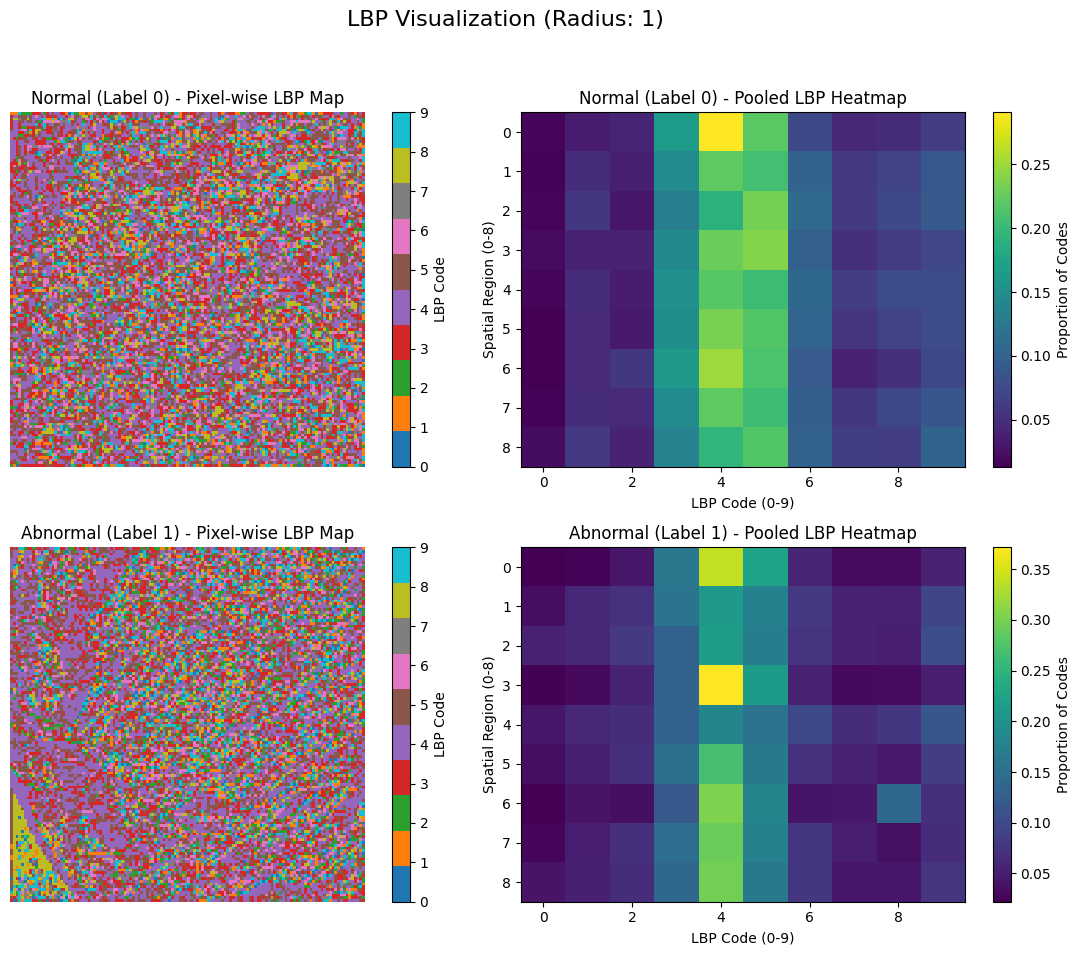

[INFO] Train samples: 258 Test samples: 66
[INFO] Running inner grid-search for RandomForest...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
[INFO] Best RandomForest params: {'clf__max_depth': 6, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 300}
[INFO] Running inner grid-search for SVM...
Fitting 4 folds for each of 6 candidates, totalling 24 fits
[INFO] Best SVM params: {'clf__C': 1, 'clf__gamma': 'scale'}

=== Held-out evaluation: RandomForest (best) ===
Accuracy: 0.8636363636363636
Recall: 0.75
AUC: 0.8908730158730158
Confusion Matrix:
 [[39  3]
 [ 6 18]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        42
           1       0.86      0.75      0.80        24

    accuracy                           0.86        66
   macro avg       0.86      0.84      0.85        66
weighted avg       0.86      0.86      0.86        66


=== Held-out evaluation: SVM (best) ===
Accuracy: 0.8636363636363636
Recall: 0.75
AUC: 

In [38]:
# Applying the LBP and GLCM and Classifier
def main():
    print("[INFO] Reading metadata...")
    df = read_metadata(META_PATH)
    refs = sorted([f for f in os.listdir(IMAGES_DIR) if f.lower().endswith('.pgm')])
    print(f"[INFO] Found {len(refs)} image files in {IMAGES_DIR}")
    radii = pd.to_numeric(df['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii.median()) if radii.size > 0 else 48
    print("[INFO] median radius:", median_radius)

    # ROI extraction
    rois = []
    rois_raw = []   # keep a raw copy (pre-CLAHE) for comparisons
    labels = []
    groups = []
    ref_list = []

    for fname in refs:
        ref = os.path.splitext(fname)[0]
        row = df[df['REFNUM'] == ref]
        if row.empty:
            continue
        row = row.iloc[0]
        img_path = os.path.join(IMAGES_DIR, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print("[WARN] cannot read", img_path); continue

        label = int(row['CANCER'])
        x, y, r = row['X'], row['Y'], row['RADIUS']

        if label == 1 and pd.notna(x) and pd.notna(y) and pd.notna(r):
            cx = int(float(x))
            cy = int(IMAGE_SIZE - float(y))  # convert bottom-left MIAS to top-left indexing
            rr = int(max(int(r), 8))
            roi = crop_square(img, cx, cy, rr)
        else:
            cx = img.shape[1] // 2
            cy = img.shape[0] // 2
            rr = median_radius
            roi = crop_square(img, cx, cy, rr)

        roi = pad_to_min_side(roi, MIN_SIDE)
        rois_raw.append(roi.copy())
        roi_clahe = apply_clahe_to_roi(roi, clip=CLAHE_CLIP, tile=CLAHE_TILE)
        if TARGET_SIZE is not None:
            if roi_clahe.shape[0] > TARGET_SIZE or roi_clahe.shape[1] > TARGET_SIZE:
                interp = cv2.INTER_AREA
            else:
                interp = cv2.INTER_LINEAR
            roi_clahe = cv2.resize(roi_clahe, (TARGET_SIZE, TARGET_SIZE), interpolation=interp)

        rois.append(roi_clahe)
        labels.append(label)
        groups.append(ref_to_patient_id(ref))
        ref_list.append(ref)

    print(f"[INFO] Extracted {len(rois)} ROIs (CLAHE applied per-ROI).")
    if len(rois) == 0:
        raise RuntimeError("No ROIs extracted - check dataset paths and metadata.")

    # Compute LBP maps for each radius and collect global max code to set fixed bins
    print("[INFO] Computing LBP maps for radii:", LBP_RADII)
    lbp_maps_per_radius = {r: [] for r in LBP_RADII}
    max_code = 0
    for roi in rois:
        # ensure float input
        img_float = roi.astype(np.float32)
        for r in LBP_RADII:
            lbp_map = local_binary_pattern(img_float, P, r, method=LBP_METHOD)
            # LBP returns floats; convert to ints safely
            lbp_int = np.round(lbp_map).astype(int)
            lbp_maps_per_radius[r].append(lbp_int)
            max_code = max(max_code, int(lbp_int.max()))

    n_lbp_bins = max_code + 1
    print(f"[INFO] Determined LBP n_bins = {n_lbp_bins}")

    # Build feature matrices
    X_lbp_parts = []  # will contain per-radius pooled LBP flattened
    X_glcm = []
    print("[INFO] Building pooled LBP histograms and GLCM features for each ROI...")
    for idx, roi in enumerate(rois):
        roi_uint8 = roi.astype(np.uint8)
        # LBP pooled for each radius, concatenate
        lbp_concat = []
        for r in LBP_RADII:
            lbp_map = lbp_maps_per_radius[r][idx]
            M = pooled_lbp_matrix(lbp_map, G=POOL_G, n_bins=n_lbp_bins)  # shape (G*G, n_bins)
            lbp_concat.append(M.ravel())
            
            # #  Plot LBP Heatmap for the first ROI
            # if idx == 0 and r == LBP_RADII[1]: # Plot only for the first image and first radius
            #     plt.figure(figsize=(8, 4))
            #     plt.imshow(M, aspect='auto', cmap='viridis')
            #     plt.title(f"Pooled LBP Heatmap for First ROI (Radius: {r})")
            #     plt.ylabel(f"Spatial Region (0-{POOL_G*POOL_G-1})")
            #     plt.xlabel(f"LBP Code (0-{n_lbp_bins-1})")
            #     plt.colorbar(label='Proportion of LBP Codes')
            #     plt.show()
            # --- End of New Code Block ---
        lbp_vec = np.hstack(lbp_concat)
        X_lbp_parts.append(lbp_vec)

        
        
        # GLCM features (quantized)
        glcm_feats = extract_glcm_features(roi_uint8, distances=GLCM_DISTANCES, angles=GLCM_ANGLES, levels=GLCM_LEVELS)
        X_glcm.append(glcm_feats)

    X_lbp = np.vstack(X_lbp_parts)
    X_glcm = np.vstack(X_glcm)
    X = np.hstack([X_glcm, X_lbp])
    y = np.array(labels)
    groups_arr = np.array(groups)

    # --- New Code Block to Create and Print Sorted GLCM DataFrame ---

    # =================================
    glcm_props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    glcm_names = []
    for p in glcm_props:
        glcm_names.extend([f"{p}_mean", f"{p}_var"])

    # Create a DataFrame from the GLCM features and their names
    glcm_df = pd.DataFrame(X_glcm, columns=glcm_names)
    
    # Add the labels for context
    glcm_df['label'] = y

    # Sort the DataFrame by the 'contrast_mean' feature in descending order
    sorted_glcm_df = glcm_df.sort_values(by='contrast_mean', ascending=False)

    print("\\n--- Sorted GLCM Feature DataFrame (Top 5 Rows) ---")
    print(glcm_df.head())
    print("-" * 50)
    # =====================================

    print("[INFO] Feature shapes: X_glcm", X_glcm.shape, "X_lbp", X_lbp.shape, "combined X", X.shape)
    print("Label counts:", Counter(y))
    plot_lbp_visualizations(rois, labels, lbp_maps_per_radius, POOL_G, LBP_RADII, n_lbp_bins)
    # safety check
    if np.isnan(X).any():
        raise RuntimeError("NaN found in features!")

    # Create feature names for mapping importances
    glcm_props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    glcm_names = []
    for p in glcm_props:
        glcm_names += [f"{p}_mean", f"{p}_var"]
    lbp_names = []
    region_count = POOL_G * POOL_G
    for r in LBP_RADII:
        for region_ix in range(region_count):
            for code in range(n_lbp_bins):
                lbp_names.append(f"LBP_R{r}_r{region_ix:02d}_c{code:03d}")
    feature_names = glcm_names + lbp_names
    assert X.shape[1] == len(feature_names)

    # ---------------- train/test split (group-aware held-out) ----------------
    gss = GroupShuffleSplit(n_splits=1, test_size=HOLDOUT_TEST_SIZE, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(X, y, groups_arr))
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    groups_tr, groups_te = groups_arr[train_idx], groups_arr[test_idx]
    print("[INFO] Train samples:", X_tr.shape[0], "Test samples:", X_te.shape[0])

    # Build pipelines for the fueature selection
    selector = SelectKBest(mutual_info_classif, k=min(SELECT_K, X_tr.shape[1]))

    # If SMOTE available, put inside ImbPipeline, else use sklearn Pipeline and class_weight
    if USE_SMOTE:
        rf_pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
        ])
        svm_pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
        ])
    else:
        rf_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
        ])
        svm_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
        ])

    # inner CV uses GroupKFold on training set
    def run_gridsearch(pipeline, param_grid, X_train, y_train, groups_train, name="model"):
        inner_cv = GroupKFold(n_splits=INNER_SPLITS)
        gs = GridSearchCV(pipeline, param_grid, cv=inner_cv.split(X_train, y_train, groups_train),
                          scoring='roc_auc', n_jobs=-1, verbose=2)
        gs.fit(X_train, y_train)
        print(f"[INFO] Best {name} params:", gs.best_params_)
        return gs.best_estimator_, gs

    print("[INFO] Running inner grid-search for RandomForest...")
    best_rf, rf_gs = run_gridsearch(rf_pipeline, RF_PARAM_GRID, X_tr, y_tr, groups_tr, name="RandomForest")

    print("[INFO] Running inner grid-search for SVM...")
    best_svm, svm_gs = run_gridsearch(svm_pipeline, SVM_PARAM_GRID, X_tr, y_tr, groups_tr, name="SVM")

    # Evaluate on held-out test set
    def evaluate_model(est, X_test, y_test, name="model"):
        y_pred = est.predict(X_test)
        if hasattr(est, "predict_proba"):
            try:
                y_prob = est.predict_proba(X_test)[:, 1]
            except Exception:
                y_prob = None
        else:
            y_prob = None
        print(f"\n=== Held-out evaluation: {name} ===")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Recall:", recall_score(y_test, y_pred, zero_division=0))
        if y_prob is not None and len(np.unique(y_test)) > 1:
            print("AUC:", roc_auc_score(y_test, y_prob))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        return y_pred, y_prob

    ypred_rf, yprob_rf = evaluate_model(best_rf, X_te, y_te, name="RandomForest (best)")
    ypred_svm, yprob_svm = evaluate_model(best_svm, X_te, y_te, name="SVM (best)")

    

if __name__ == "__main__":
    main()
